# **Importacion de librerias necesarias**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import gdown
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# **Carga del dataset e interpolacion de datos**

In [ ]:
#Se sube el archivo y leerlo
file_id = '1LMTP-xXnkvMqaZudyIn097B6FisZ_KqN'
url = f'https://drive.google.com/uc?id={file_id}'
output_file = 'DatosOriginales.csv'
gdown.download(url, output_file, quiet=False)
df = pd.read_csv(output_file, decimal=',')

#Variables o columnas a interpolar a interpolar
cols_to_interpolate = ['P1', 'P2', 'P3', 'T1', 'T2', 'T3', 'T4']
for col in cols_to_interpolate:
    if df[col].dtype == object:
        df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

x_original = np.linspace(0, 1, num=len(df))
x_new = np.linspace(0, 1, num=360)
df_expanded = pd.DataFrame()

if 'Alimento' in df.columns: df_expanded['Alimento'] = [df['Alimento'].iloc[0]] * 360

for col in cols_to_interpolate:
    f_interp = interp1d(x_original, df[col].values, kind='cubic')
    df_expanded[col] = f_interp(x_new)

print(f"Datos Interpolados: {df_expanded.shape}")


Downloading...
From: https://drive.google.com/uc?id=1LMTP-xXnkvMqaZudyIn097B6FisZ_KqN
To: /content/DatosOriginales.csv
100%|██████████| 3.58k/3.58k [00:00<00:00, 11.1MB/s]

Datos Interpolados: (360, 7)


# **Preprocesamiento de datos**

In [ ]:

input_cols = ['P2', 'P3', 'T1', 'T2', 'T3', 'T4'] # Variables independientes
target_col = ['P1']  # Variable dependiente

data_input = df_expanded[input_cols].values
data_target = df_expanded[target_col].values

# Usamos 2escaladores diferentes
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_x.fit_transform(data_input)
y_scaled = scaler_y.fit_transform(data_target)

# Funcion de ventana para tomar X e Y
def create_dataset_separated(X_data, y_data, look_back=1):
    dataX, dataY = [], []


    #  alineamos el pasado de X con el futuro de Y
    for i in range(len(X_data) - look_back):
        # Tomamos la ventana de 30 pasos de las variables de dependeientes
        a = X_data[i:(i + look_back), :]
        dataX.append(a)
        # Tomamos el valor de P1 actual
        # Aquí predecimos P1 en el mismo instante que termina la ventana de los otros
        dataY.append(y_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 30
X, y = create_dataset_separated(X_scaled, y_scaled, look_back)

# Split de datos de entreno y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)
# 6 sensores
num_features = len(input_cols)
print(f"Dimensiones X_train: {X_train.shape}")

Dimensiones X_train: (264, 30, 6)


# **MODELO LSTM**

In [ ]:

model = Sequential()
model.add(Input(shape=(look_back, num_features)))

#================CAPAS DE NEURONAS================
#Capa de procesamiento
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dropout(0.2))

#Capa densa
model.add(Dense(32, activation='relu'))
# Capa de salida
model.add(Dense(1, activation='linear'))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

#Earlystoping para evitar sobreajuste
early_stop = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)



# **Hiperparametros**

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=0
)


# **Resultados de la prediccion del modelo**

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

RESULTADOS 
R2 Score: 0.9978
MAE: 7.18 gramos
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


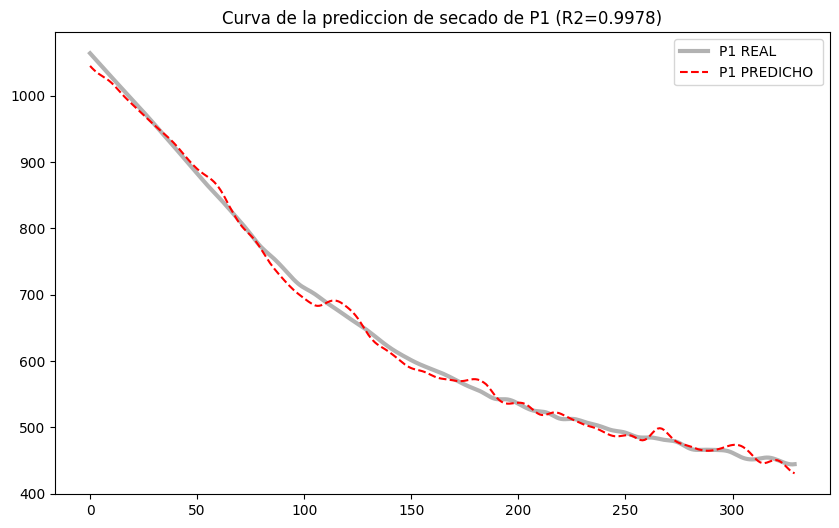

In [ ]:

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# scaler_y exclusivo para P1
train_predict_real = scaler_y.inverse_transform(train_predict)
y_train_real = scaler_y.inverse_transform(y_train.reshape(-1, 1))

test_predict_real = scaler_y.inverse_transform(test_predict)
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Metricas
r2 = r2_score(y_test_real, test_predict_real)
mae = mean_absolute_error(y_test_real, test_predict_real)

print("\n" + "="*40)
print(f"RESULTADOS ")
print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.2f} gramos")
print("="*40)

# Grafica
plt.figure(figsize=(10, 6))
# graficar correctamente la curva completa:
full_X, full_y = create_dataset_separated(X_scaled, y_scaled, look_back)
full_pred = model.predict(full_X)
full_pred_real = scaler_y.inverse_transform(full_pred)
full_y_real = scaler_y.inverse_transform(full_y.reshape(-1, 1))

plt.plot(full_y_real, label='P1 REAL', color='black', alpha=0.3, linewidth=3)
plt.plot(full_pred_real, label='P1 PREDICHO ', color='red', linestyle='--')
plt.title(f'Curva de la prediccion de secado de P1 (R2={r2:.4f})')
plt.legend()
plt.show()